### Camera Calibration - Chessboard Example

In [ ]:
# ref and text explanation from: https://docs.opencv.org/4.5.2/dc/dbb/tutorial_py_calibration.html

In [5]:
import numpy as np
import cv2 
import glob

In [20]:
import sys
sys.path.append('C:/Users/Mafeus/Desktop/Git_Repos/OpenCV')
import OpCV_Utils

#### Load Chessboard images:

In [21]:
images = glob.glob('chessboard/*.jpg')

#### Get Object 3D points and Image 2D points

In [54]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
imgs = [] # img list
titles = []

for fname in images:
    
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,6), None)
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (7,6), corners2, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)
        imgs.append(img.copy())
        titles.append('')
        
cv2.destroyAllWindows()

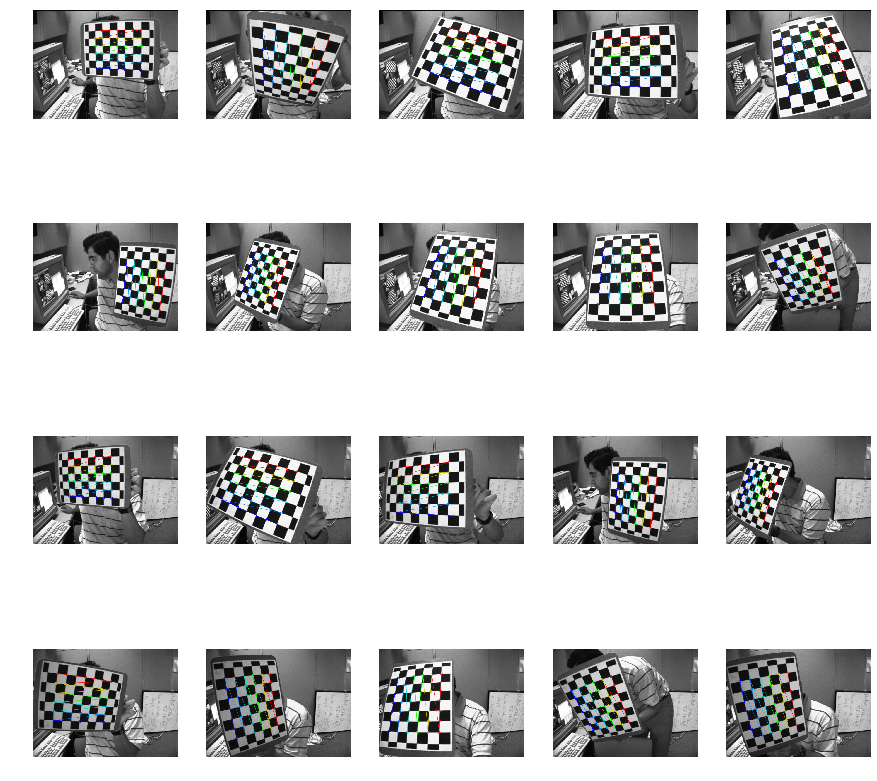

In [55]:
OpCV_Utils.show_multiple_imgs_plt([(imgs[:5]), (imgs[5:11]), (imgs[11:16]), (imgs[16:21])], 
                                    [(titles[:5]), (titles[5:11]), (titles[11:16]), (titles[16:21])], fig_size=(15,15))

### Calibration
* Now that we have our object points and image points, we are ready to go for calibration. We can use the function, cv.calibrateCamera() which returns the camera matrix, distortion coefficients, rotation and translation vectors etc.

In [99]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print('Camera Matrix:')
print(mtx, '\n')
print('Distortion Coefs:') 
print(dist)

Camera Matrix:
[[536.39560293   0.         334.03199671]
 [  0.         536.43966656 239.43394616]
 [  0.           0.           1.        ]] 

Distortion Coefs:
[[-3.10623604e-01  2.22524887e-01  6.87555669e-04 -2.27914789e-04
  -1.94685111e-01]]


### Undistortion
* Now, we can take an image and undistort it. OpenCV comes with two methods for doing this. However first, we can refine the camera matrix based on a free scaling parameter using cv.getOptimalNewCameraMatrix(). If the scaling parameter alpha=0, it returns undistorted image with minimum unwanted pixels. So it may even remove some pixels at image corners. If alpha=1, all pixels are retained with some extra black images. This function also returns an image ROI which can be used to crop the result.

In [57]:
img = cv2.imread('chessboard/left12.jpg')
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

#### Using cv2.undistort()
* This is the easiest way. Just call the function and use ROI obtained above to crop the result.

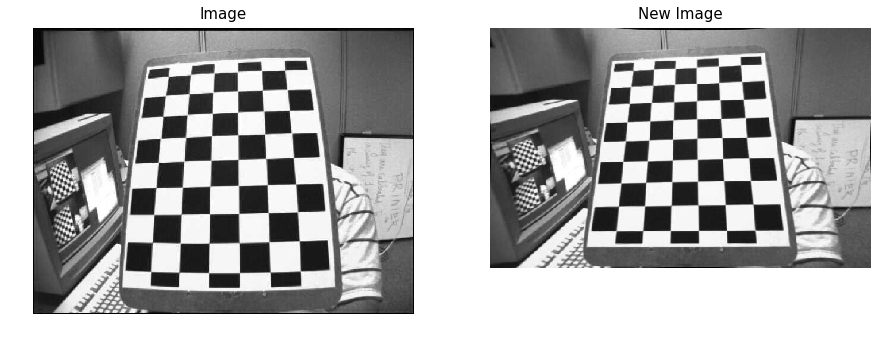

In [60]:
# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('calibresult.png', dst)

OpCV_Utils.show_multiple_imgs_plt([[img, dst]], [['Image', 'New Image']], fig_size=(15,15))

#### Using remapping
* This way is a little bit more difficult. First, find a mapping function from the distorted image to the undistorted image. Then use the remap function.

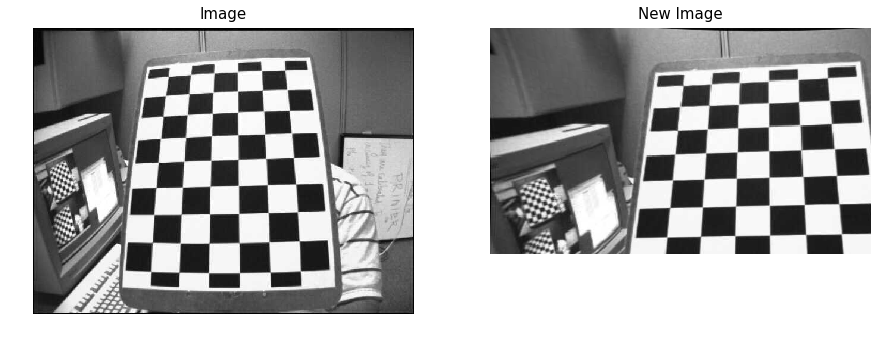

In [61]:
# undistort
mapx, mapy = cv2.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('calibresult_remap.png', dst)

OpCV_Utils.show_multiple_imgs_plt([[img, dst]], [['Image', 'New Image']], fig_size=(15,15))

* Now you can store the camera matrix and distortion coefficients using write functions in NumPy (np.savez, np.savetxt etc) for future uses.

#### Re-projection Error
* Re-projection error gives a good estimation of just how exact the found parameters are. The closer the re-projection error is to zero, the more accurate the parameters we found are. Given the intrinsic, distortion, rotation and translation matrices, we must first transform the object point to image point using cv.projectPoints(). Then, we can calculate the absolute norm between what we got with our transformation and the corner finding algorithm. To find the average error, we calculate the arithmetical mean of the errors calculated for all the calibration images.

In [62]:
mean_error = 0

for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
    
print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.028317717534959454


### Homography Parameters:

In [100]:
# Selecting Chessboard Images and Getting Corners:
image_src = cv2.imread('chessboard/left12.jpg')
image_src_gray = cv2.cvtColor(image_src, cv2.COLOR_BGR2GRAY)

image_dest = cv2.imread('chessboard/left08.jpg')
image_dest_gray = cv2.cvtColor(image_dest, cv2.COLOR_BGR2GRAY)

ret, corners1 = cv2.findChessboardCorners(image_src_gray, (7,6), None)
ret, corners2 = cv2.findChessboardCorners(image_dest_gray, (7,6), None)

In [101]:
#H_matrix = cv2.getPerspectiveTransform(points1, points2) # need to be 3 or 4 points
H_matrix, status = cv2.findHomography(corners1, corners2, cv2.RANSAC, 5.0) # can be more than 4 points
num, Rs, Ts, Ns =  cv2.decomposeHomographyMat(H_matrix, mtx)

print('Homography Matrix H:', '\n', H_matrix, '\n')
print('Rotation Parameters:', '\n', Rs, '\n')
print('Translation Parameters:', '\n', Rs, '\n')
print('Normal Vector:', '\n', Ns, '\n')
print('Solutions', num)

Homography Matrix H: 
 [[ 7.41160663e-01 -1.93877890e-01  1.14632942e+02]
 [ 1.01715984e-01  9.11359440e-01 -2.61151680e+01]
 [-3.01820425e-04  1.19975588e-04  1.00000000e+00]] 

Rotation Parameters: 
 [array([[ 0.96309574, -0.2690474 ,  0.00775159],
       [ 0.26910985,  0.9630709 , -0.00862177],
       [-0.00514566,  0.01038962,  0.99993279]]), array([[ 0.96309574, -0.2690474 ,  0.00775159],
       [ 0.26910985,  0.9630709 , -0.00862177],
       [-0.00514566,  0.01038962,  0.99993279]]), array([[ 0.96308953, -0.18717798,  0.19345017],
       [ 0.19288135,  0.98116145, -0.01090819],
       [-0.18776407,  0.0478185 ,  0.98104946]]), array([[ 0.96308953, -0.18717798,  0.19345017],
       [ 0.19288135,  0.98116145, -0.01090819],
       [-0.18776407,  0.0478185 ,  0.98104946]])] 

Translation Parameters: 
 [array([[ 0.96309574, -0.2690474 ,  0.00775159],
       [ 0.26910985,  0.9630709 , -0.00862177],
       [-0.00514566,  0.01038962,  0.99993279]]), array([[ 0.96309574, -0.2690474 ,  0.0

#### Warping Perspective:

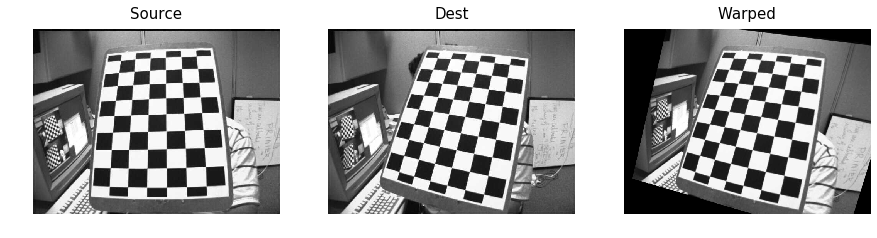

In [97]:
img_warp = cv2.warpPerspective(image_src, H_matrix, (image_src.shape[1],image_src.shape[0]))

OpCV_Utils.show_multiple_imgs_plt([[image_src, image_dest, img_warp]], [['Source', 'Dest', 'Warped']], fig_size =(15,15))